# To Do

> Remove tensorflow adapation from gpr.py and focus on learning how to implement GPR and MCMC from scratch in tensorflow

>

In [1]:
from time import time
import numpy as np
import astropy.units as u
import astropy.constants as c
import astropy.io.fits as pf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import gpr
import mcmc
import forAustin as fa

W0705 19:57:57.094184 140576558245696 logger.py:200] AstropyDeprecationWarning: astropy.extern.six will be removed in 4.0, use the six module directly if it is still needed


In [2]:
sample = np.array([-0.2, 0, 0, 0.2])
sample = None
GP = gpr.GPR(
    '/media/data/austinfortino/austinFull.fits',
    500,
    sample=sample,
    verbose=True,
    eps=0,
    test_size=0.2,
    random_state=0)

Extracting exposure from fits file...
Filename: /media/data/austinfortino/austinFull.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  Exposures     1 BinTableHDU     47   2820R x 19C   [1D, 1D, 4A, 1D, 8A, 1D, 1J, 1J, 1D, 1D, 8A, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D]   
  2  RESIDUALS     1 BinTableHDU     25   73818788R x 8C   [I, J, D, D, D, D, D, L]   

Extracting exposure data...
Splitting data into training and testing sets...
Generating white noise covariance function...


Generating elliptical covariance function...
Solving for posterior...
Posterior found in 20.966 seconds.

Current Log Marginal Likelihood: -4682681.883536773
Fraction of test points within 1 standard deviation(s) of posterior predictive mean:
dx: 0.021443672606463304; dy: 0.021443672606463304
Standard deviation of validation residuals: dx 19.853, dy 18.528
Standard deviation of Gaussian Process residuals: dx 17.4, dy 14.121
The ratio of std(valid) / std(GP): dx 1.141, dy 1.312


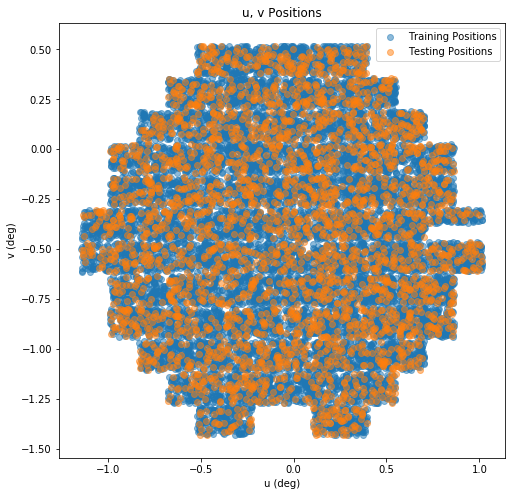

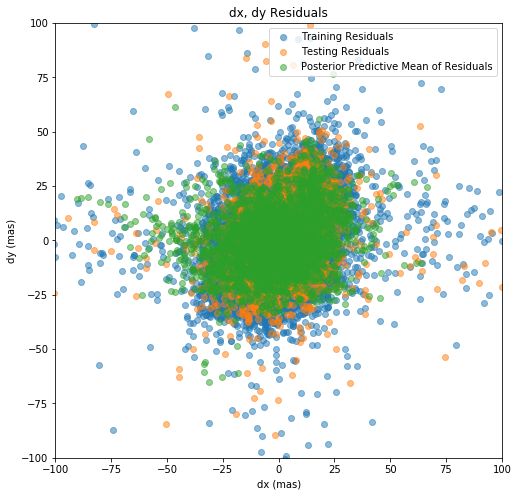

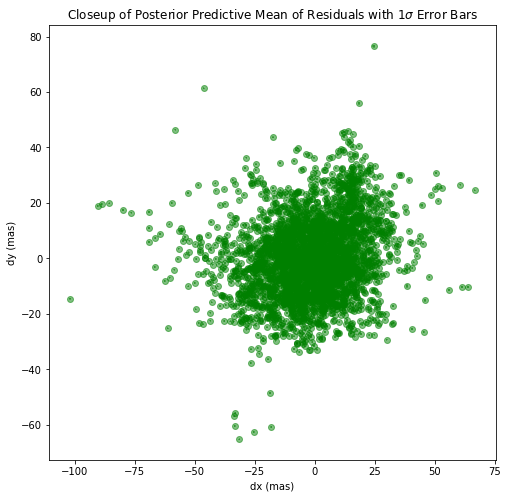

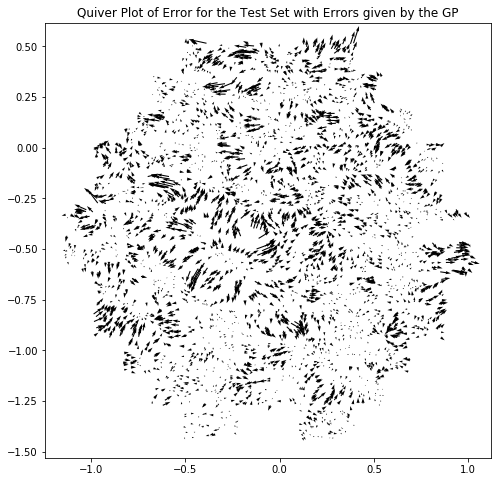

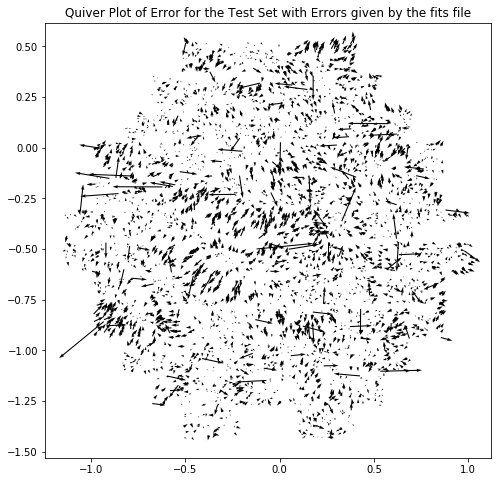

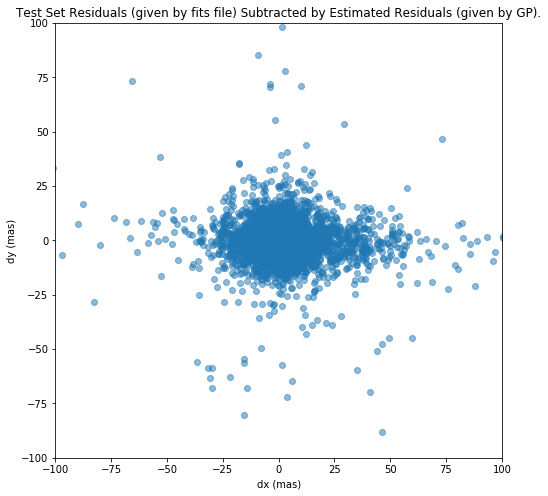

CPU times: user 5min 37s, sys: 27 s, total: 6min 4s
Wall time: 30 s


In [3]:
%%time
var_s = 100
sigma_x = (5 * u.arcmin).to(u.deg).value
sigma_y = (5 * u.arcmin).to(u.deg).value
phi = (0 * u.deg).to(u.rad).value
theta = (var_s, sigma_x, sigma_y, phi)
GP.fit(theta)
GP.summary()

Generating elliptical covariance function...
Solving for posterior...
Posterior found in 167.79 seconds.

Current Log Marginal Likelihood: -115706.66928938404
Fraction of test points within 1 standard deviation(s) of posterior predictive mean:
dx: 0.7988523104802174; dy: 0.7988523104802174
Standard deviation of validation residuals: dx 19.853, dy 18.528
Standard deviation of Gaussian Process residuals: dx 16.663, dy 13.944
The ratio of std(valid) / std(GP): dx 1.191, dy 1.329


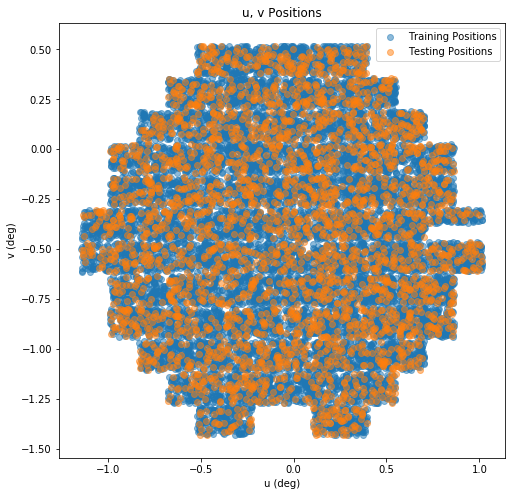

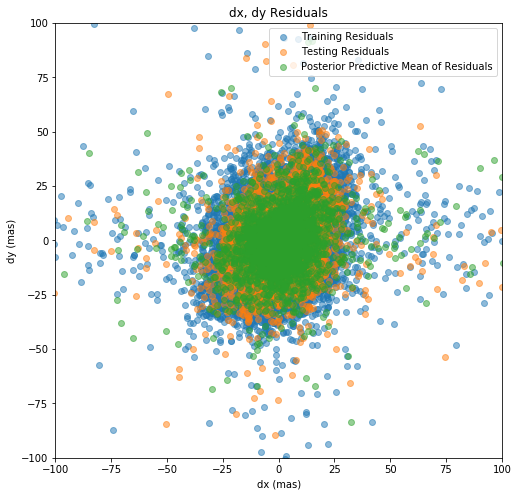

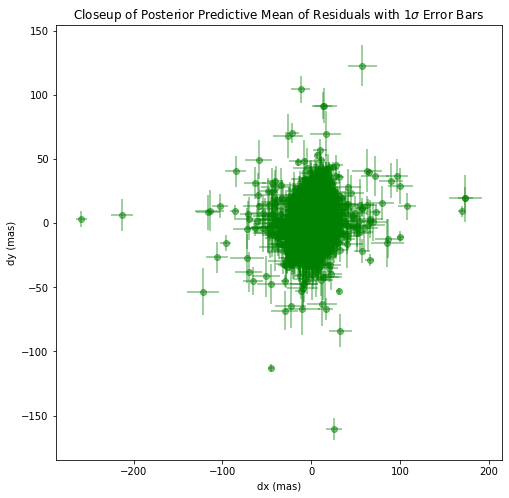

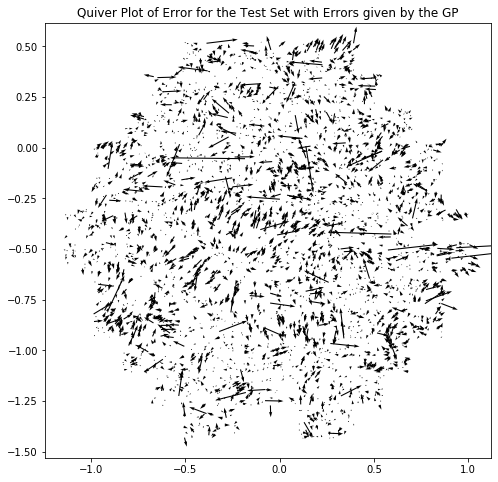

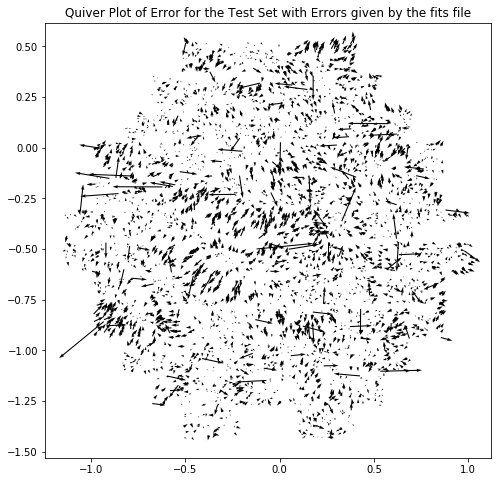

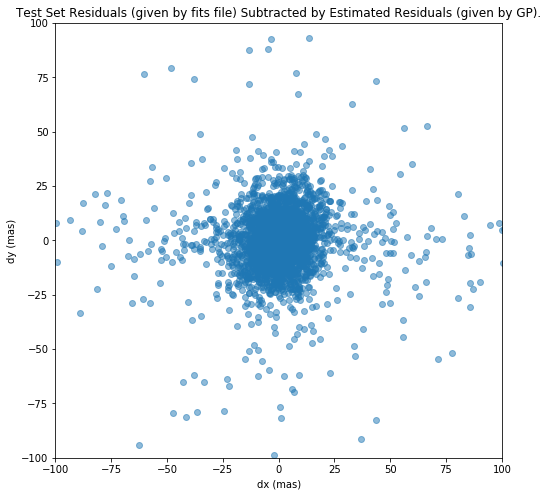

CPU times: user 54min 11s, sys: 48.3 s, total: 54min 59s
Wall time: 2min 59s


In [4]:
%%time
var_s = 460
sigma_x = 0.00175
sigma_y = 0.025
phi = (0 * u.deg).to(u.rad).value
theta = (var_s, sigma_x, sigma_y, phi)
GP.fit(theta)
GP.summary()